In [1]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import random
from sentence_transformers import util
import helper_functions as hp
from torch.optim.lr_scheduler import StepLR
#from imports import Dataset,torch,np,random,DataLoader,util
# DATASET CLASSES PYTORCH 
# import helper_functions as hp

C:\Users\en750\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
class CustomDatasetTriplet(Dataset):
    def __init__(self, dataset):#store the dataset in memory for faster acess
        self.edit_sentences = [val[4] for val in dataset]
        self.paraphrase_sentences = [val[5] for val in dataset]
        self.neigbhourhood_sentences = [val[6] for val in dataset]
        self.edit_vectors = [val[0] for val in dataset]
        self.paraphrase_vectors = [val[1] for val in dataset]
        self.neighbourhood_vectors = [val[2] for val in dataset]
    def __len__(self):
        return len(self.edit_vectors)

    def __getitem__(self, index):
        emb1 = torch.tensor(self.edit_vectors[index], dtype=torch.float32)
        emb2 = torch.tensor(self.paraphrase_vectors[index], dtype=torch.float32)
        emb3 = torch.tensor(self.neighbourhood_vectors[index], dtype=torch.float32)
        sent1 = self.edit_sentences[index]
        sent2 = self.paraphrase_sentences[index]
        sent3 = self.neigbhourhood_sentences[index]
        
        return emb1, emb2, emb3, sent1, sent2, sent3


class CustomDataset(Dataset):#do not duplicate data approach
    def __init__(self, dataset, device):
        self.dataset = np.array(dataset, dtype=object)
        self.device = device
    
    def __len__(self):
        return len(self.dataset)

    def total_indexes(self):
        return np.unique(self.dataset[:, 3])

    def get_row_indexes(self, target_sample_index):
        return np.where(self.dataset[:, 3] == target_sample_index)[0]

    def get_samples_at_data_index(self, target_sample_index):
        row_indexes = np.where(self.dataset[:, 3] == target_sample_index)[0]
        embs_edit, embs_paraphrase, embs_neighbour, row_indexes, sents_edit, sents_paraphrase, sents_neigbhour = [], [], [], [], [], [], []
        
        for index in row_indexes:
            embs_edit.append(torch.tensor(self.dataset[index][0], dtype=torch.float32).to(self.device))
            embs_paraphrase.append(torch.tensor(self.dataset[index][1], dtype=torch.float32).to(self.device))
            embs_neighbour.append(torch.tensor(self.dataset[index][2], dtype=torch.float32).to(self.device))
            row_indexes.append(self.dataset[index][3])
            sents_edit.append(self.dataset[index][4])
            sents_paraphrase.append(self.dataset[index][5])
            sents_neigbhour.append(self.dataset[index][6])
        
        return embs_edit, embs_paraphrase, embs_neighbour, row_indexes, sents_edit, sents_paraphrase, sents_neigbhour

    def __getitem__(self, index):
        emb_edit = torch.tensor(self.dataset[index][0], dtype=torch.float32).to(self.device)
        emb_paraphrase = torch.tensor(self.dataset[index][1], dtype=torch.float32).to(self.device)
        emb_neighbour = torch.tensor(self.dataset[index][2], dtype=torch.float32).to(self.device)
        row_index = self.dataset[index][3]
        sent_edit = self.dataset[index][4]
        sent_paraphrase = self.dataset[index][5]
        sent_neigbhour = self.dataset[index][6]
        #print(self.dataset[index][2])
        
        return emb_edit, emb_paraphrase, emb_neighbour, row_index, sent_edit, sent_paraphrase, sent_neigbhour


def get_data_loader(dataset_paired, batch_size=2, shuffle=True, device="cpu"):
    dataset_pt = CustomDataset(dataset_paired, device)
    data_loader = DataLoader(dataset_pt, batch_size=batch_size, shuffle=shuffle)
    return data_loader

In [3]:
def create_dataset_tripletloss(dataset,mode=0,label_reversal=False):
    """
    The dataset is created in a set format for both test and train sets.
    The first value will always be the edit vector, the second a paraphrase vector and the thirt a neighbour vector.
    This is followed by the row index, the text prompts for edit, praraphrase and neighbours

    While using the test set the test paraphrase will be in all the rows but need to evaluated only once and can be ignored there after.

    """

        
    if(label_reversal==True):
        paraphrase=0
        neightbour=1
    else:
        paraphrase=1
        neightbour=0

    dataset_paired_train=[]
    dataset_paired_test=[]
   
    for row_index,row in enumerate(dataset):#iterate over the dataset
        index_control_neighbourhood=len(row["vectors_neighborhood_prompts_high_sim"])-1#number of entries in the neighbourhood 
        # print(index_control_neighbourhood)
        num_elements_to_select = min(3, len(row["openai_usable_paraphrases_embeddings"]))#add 3 max open ai paraphrases
        #with openai paraphrases set to 3 and 1 paraphrase from the dataset there are 4 elements, total neighbourhood elements are 5
        #I have made the code such that there is sampling for paraphrase for 5th element based on random sampling, othere wise you can just use 4 elements from neighbourhood
        sampled_indices, sampled_elements = zip(*random.sample(list(enumerate(row["openai_usable_paraphrases_embeddings"])), num_elements_to_select))# sample and get indexes
        for index, vector_openai in zip(sampled_indices, sampled_elements):
            dataset_paired_train.append([row["vector_edited_prompt"],vector_openai,row["vectors_neighborhood_prompts_high_sim"][abs(index_control_neighbourhood)],row_index,
                                        row["edited_prompt"][0],row["openai_usable_paraphrases"][index],row["neighborhood_prompts_high_sim"][abs(index_control_neighbourhood)]])
            index_control_neighbourhood=index_control_neighbourhood-1

        dataset_paired_train.append([row["vector_edited_prompt"],row["vector_edited_prompt_paraphrases_processed"],row["vectors_neighborhood_prompts_high_sim"][abs(index_control_neighbourhood)],row_index,
                                        row["edited_prompt"][0],row["openai_usable_paraphrases"][index],row["neighborhood_prompts_high_sim"][abs(index_control_neighbourhood)]])
        index_control_neighbourhood=index_control_neighbourhood-1
        #at this point the index is zero with one neigbour not being used. you can add it if you want to.

            
        #test set
        for index,vector in enumerate(row["vectors_neighborhood_prompts_low_sim"]):
            dataset_paired_test.append([row["vector_edited_prompt"],row["vector_edited_prompt_paraphrases_processed_testing"],vector,row_index,
                                        row["edited_prompt"][0],row["edited_prompt_paraphrases_processed_testing"],row["neighborhood_prompts_low_sim"][index]])
      
            

    return  dataset_paired_train,dataset_paired_test

In [4]:
#testing the dataloaders
import json,linecache
def read_dataset_reduced(file_path_read_dataset: str,data_size):
    dataset=[]
    values_list = list(range(1, data_size+1))
    for index,number in enumerate(values_list):

        try:
            data_entry = json.loads(linecache.getline(file_path_read_dataset, number).strip())
            dataset.append(data_entry)
        except Exception as e:
            print(index)
            print(e)
    return dataset
file_path_dataset="counterfact_test_2_lama_merged.jsonl"
num_samples=4999
dataset=read_dataset_reduced(file_path_dataset,data_size=num_samples) 



In [5]:
dataset_paired_train,dataset_paired_test=create_dataset_tripletloss(dataset)
input_dim = len(dataset_paired_train[0][0][0])  
print(f"output vector length: {input_dim}")

output vector length: 4096


In [6]:
dataset[0]["vector_edited_prompt"]

[[0.013264707289636135,
  -0.00912494957447052,
  -0.012226740829646587,
  -0.004331137984991074,
  -0.00309940823353827,
  -0.007578341290354729,
  -0.01962381601333618,
  0.005121668800711632,
  0.013790958561003208,
  0.014035354368388653,
  -0.02056184411048889,
  0.010514743626117706,
  0.009058677591383457,
  0.01852807030081749,
  -0.038583021610975266,
  0.0260747279971838,
  0.03758371248841286,
  0.007755286991596222,
  0.010370536707341671,
  0.013258260674774647,
  0.005355688277631998,
  -0.008646432310342789,
  0.0130776884034276,
  -0.01654944382607937,
  0.015902776271104813,
  0.0028951175045222044,
  -0.004628690425306559,
  -0.01375229936093092,
  0.0037316454108804464,
  0.0034909520763903856,
  -0.003184191882610321,
  0.010756838135421276,
  0.006468016654253006,
  0.011493449099361897,
  0.023753097280859947,
  -0.054018691182136536,
  -0.01525462418794632,
  -0.005231982562690973,
  -0.02546858787536621,
  -0.0017066734144464135,
  0.01332617923617363,
  0.02821

In [400]:
dataset_paired_train[0][0]

[[0.013264707289636135,
  -0.00912494957447052,
  -0.012226740829646587,
  -0.004331137984991074,
  -0.00309940823353827,
  -0.007578341290354729,
  -0.01962381601333618,
  0.005121668800711632,
  0.013790958561003208,
  0.014035354368388653,
  -0.02056184411048889,
  0.010514743626117706,
  0.009058677591383457,
  0.01852807030081749,
  -0.038583021610975266,
  0.0260747279971838,
  0.03758371248841286,
  0.007755286991596222,
  0.010370536707341671,
  0.013258260674774647,
  0.005355688277631998,
  -0.008646432310342789,
  0.0130776884034276,
  -0.01654944382607937,
  0.015902776271104813,
  0.0028951175045222044,
  -0.004628690425306559,
  -0.01375229936093092,
  0.0037316454108804464,
  0.0034909520763903856,
  -0.003184191882610321,
  0.010756838135421276,
  0.006468016654253006,
  0.011493449099361897,
  0.023753097280859947,
  -0.054018691182136536,
  -0.01525462418794632,
  -0.005231982562690973,
  -0.02546858787536621,
  -0.0017066734144464135,
  0.01332617923617363,
  0.02821

In [113]:
dataset[0].keys()

dict_keys(['orignal_prompt', 'edited_prompt', 'edited_prompt_paraphrases_processed', 'edited_prompt_paraphrases_unprocessed', 'edited_prompt_paraphrases_processed_testing', 'edited_prompt_paraphrases_unprocessed_testing', 'neighborhood_prompts_high_sim', 'neighborhood_prompts_low_sim', 'vector_edited_prompt', 'vector_edited_prompt_paraphrases_processed', 'vector_edited_prompt_paraphrases_processed_testing', 'vectors_neighborhood_prompts_high_sim', 'vectors_neighborhood_prompts_low_sim', 'openai_usable_paraphrases', 'openai_notused_paraphrases', 'openai_usable_paraphrases_embeddings'])

In [114]:
dataset_paired_train[0][2]

[[0.012706171721220016,
  0.0076879775151610374,
  0.017193742096424103,
  -0.005024240352213383,
  -0.007981594651937485,
  -0.013911598362028599,
  -0.005961188115179539,
  0.017822545021772385,
  0.018259063363075256,
  0.023395510390400887,
  -0.009489503689110279,
  0.0022755491081625223,
  0.004247075878083706,
  0.0047682467848062515,
  -0.0400146022439003,
  0.005508214235305786,
  0.0016996259801089764,
  -0.0030946284532546997,
  0.017037684097886086,
  0.0026056072674691677,
  -0.0022559375502169132,
  0.009978622198104858,
  -0.01745143160223961,
  -0.006487458478659391,
  0.013639310374855995,
  -0.0016115179751068354,
  -0.023808594793081284,
  -0.002418676856905222,
  -0.0008118670666590333,
  0.006752493791282177,
  0.01106975506991148,
  0.007433529943227768,
  0.014468856155872345,
  0.004149641841650009,
  0.013252759352326393,
  -0.007222592364996672,
  0.006461114156991243,
  -0.0038723659235984087,
  -0.010534721426665783,
  0.0031232130713760853,
  0.015325412154

In [115]:
dataset[0]["vectors_neighborhood_prompts_high_sim"][-1]

[[0.012706171721220016,
  0.0076879775151610374,
  0.017193742096424103,
  -0.005024240352213383,
  -0.007981594651937485,
  -0.013911598362028599,
  -0.005961188115179539,
  0.017822545021772385,
  0.018259063363075256,
  0.023395510390400887,
  -0.009489503689110279,
  0.0022755491081625223,
  0.004247075878083706,
  0.0047682467848062515,
  -0.0400146022439003,
  0.005508214235305786,
  0.0016996259801089764,
  -0.0030946284532546997,
  0.017037684097886086,
  0.0026056072674691677,
  -0.0022559375502169132,
  0.009978622198104858,
  -0.01745143160223961,
  -0.006487458478659391,
  0.013639310374855995,
  -0.0016115179751068354,
  -0.023808594793081284,
  -0.002418676856905222,
  -0.0008118670666590333,
  0.006752493791282177,
  0.01106975506991148,
  0.007433529943227768,
  0.014468856155872345,
  0.004149641841650009,
  0.013252759352326393,
  -0.007222592364996672,
  0.006461114156991243,
  -0.0038723659235984087,
  -0.010534721426665783,
  0.0031232130713760853,
  0.015325412154

In [8]:
data_loader=get_data_loader(dataset_paired_train, batch_size=1, shuffle=False, device="cpu")

In [9]:
for batch in data_loader:
    for value in batch:
        print(value)
    break

tensor([[[ 0.0133, -0.0091, -0.0122,  ..., -0.0044,  0.0212,  0.0092]]])
tensor([[[ 0.0077, -0.0073, -0.0094,  ..., -0.0176,  0.0033,  0.0177]]])
tensor([[[ 0.0127,  0.0077,  0.0172,  ...,  0.0025,  0.0012, -0.0074]]])
tensor([0])
('Angola is located in',)
('Angola is situated in the continent of',)
('Democratic Republic of the Congo is in',)


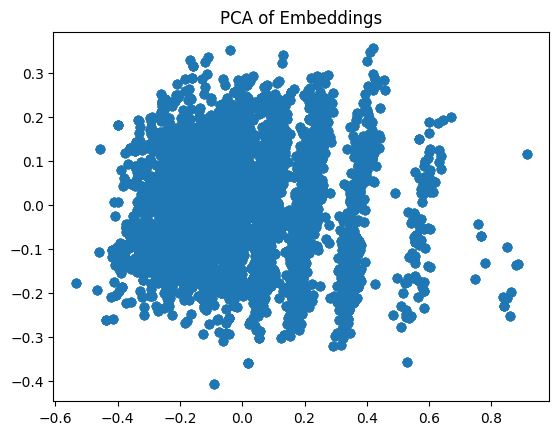

Need 1703 Dimentional to cover 95% information


In [11]:
from sklearn.decomposition import PCA

sample_vectors = [sample[0][0] for sample in dataset_paired_train]

pca = PCA(n_components=2)
reduced = pca.fit_transform(sample_vectors)

import matplotlib.pyplot as plt
plt.scatter(reduced[:, 0], reduced[:, 1])
plt.title('PCA of Embeddings')
plt.show()

pca = PCA(n_components=0.95)
reduced = pca.fit_transform(sample_vectors)
print(f"Need {reduced.shape[1]} Dimentional to cover 95% information")


In [10]:
train_loader = get_data_loader(dataset_paired_train, batch_size=16, device='cuda')
test_loader = get_data_loader(dataset_paired_test, batch_size=16, device='cuda')


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

class TripletNet(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(TripletNet, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.embedding(x)

In [12]:
import torch
import torch.nn as nn

class CustomTripletMarginLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(CustomTripletMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1)  # ||a - p||^2
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1)  # ||a - n||^2
        
        # Triplet loss 公式：max(0, ||a - p||^2 - ||a - n||^2 + margin)
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()


In [13]:
class ModifiedTripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ModifiedTripletLoss, self).__init__()
        self.margin = margin
 
    def forward(self, anchor, positive, negative):
        """
        Compute the triplet loss where:
        - The positive is always pulled closer.
        - The negative is pushed away only if within the margin.
 
        Args:
            anchor (Tensor): Embedding of the anchor sample.
            positive (Tensor): Embedding of the positive sample (same class as anchor).
            negative (Tensor): Embedding of the negative sample (different class from anchor).
 
        Returns:
            Tensor: Computed loss.
        """
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1)  # Squared Euclidean distance
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1)  # Squared Euclidean distance
 
        # Loss: Pull positive closer + Ensure negative is at least 'margin' away
        loss = pos_dist + torch.relu(self.margin - neg_dist)
        return loss.mean()

In [14]:
class SoftMarginTripletLoss(nn.Module):
    def __init__(self,margin=1.0):
        super(SoftMarginTripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1)

        diff = pos_dist + self.margin - neg_dist
        diff = torch.clamp(diff, min=-50, max=50)

        loss = torch.nn.functional.softplus(diff)
        return loss.mean()


In [15]:
import torch
import torch.nn as nn

class ModifiedTripletLoss2(nn.Module):
    def __init__(self, margin=1.0):
        super(ModifiedTripletLoss2, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = torch.sum((anchor - positive) ** 2, dim=1) 
        neg_dist = torch.sum((anchor - negative) ** 2, dim=1) 


        loss = pos_dist + torch.nn.functional.softplus(self.margin - neg_dist)

        return loss.mean()



In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = 4096
embedding_dim = 1900
model = TripletNet(input_dim, embedding_dim).to(device)

triplet_loss = nn.TripletMarginLoss(margin=1.5)
#triplet_loss = ModifiedTripletLoss(margin=1.5)
#triplet_loss = SoftMarginTripletLoss(margin=1.5)
#triplet_loss = CustomTripletMarginLoss(margin=1.5)
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for emb_edit, emb_para, emb_neigh, _, _, _, _ in train_loader:
        emb_edit = emb_edit.to(device)
        emb_para = emb_para.to(device)
        emb_neigh = emb_neigh.to(device)
        
        anchor = model(emb_edit)
        positive = model(emb_para)
        negative = model(emb_neigh)
        
        loss = triplet_loss(anchor, positive, negative)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()


    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    torch.save(model, 'Triplet_model.pth')


Epoch [1/10], Loss: 0.9200
Epoch [2/10], Loss: 0.4512
Epoch [3/10], Loss: 0.3649
Epoch [4/10], Loss: 0.2401
Epoch [5/10], Loss: 0.1702
Epoch [6/10], Loss: 0.1313
Epoch [7/10], Loss: 0.0912
Epoch [8/10], Loss: 0.0705
Epoch [9/10], Loss: 0.0536
Epoch [10/10], Loss: 0.0473


In [17]:
print(anchor.shape)
print(positive.shape)
print(negative.shape)

torch.Size([12, 1, 1900])
torch.Size([12, 1, 1900])
torch.Size([12, 1, 1900])


In [18]:
import torch.nn.functional as F
from collections import defaultdict


def compute_threshold(model, edit_vector, paraphrase_vector):
    emb_edit = model(edit_vector)
    emb_para = model(paraphrase_vector)


    dist = torch.dist(emb_edit, emb_para).item()

    return dist


In [19]:


threshold_map = defaultdict(list)



model.eval()
for edit_vector, paraphrase_vector, neighbor_vector, row_index, _, _, _ in train_loader:

    for i, idx in enumerate(row_index):
        idx = int(idx.item())  
        threshold = compute_threshold(model, edit_vector[i], paraphrase_vector[i])


        threshold_map[idx].append(threshold)


final_threshold_map = {str(k): max(v) for k, v in threshold_map.items()}


with open("threshold_map.json", "w") as f:
    json.dump(final_threshold_map, f, indent=4)

print(f"Thresholds saved for {len(final_threshold_map)} edit vectors")

Thresholds saved for 4999 edit vectors


In [20]:
import json
import torch

with open("threshold_map.json", "r") as f:
    threshold_map = json.load(f)

threshold_map = {str(k): v for k, v in threshold_map.items()}

def predict_label(model, edit_vector_test, paraphrase_vector_test, neighbor_vector_test, threshold):
    emb_edit = model(edit_vector_test)
    emb_para = model(paraphrase_vector_test)
    emb_neigh = model(neighbor_vector_test)

    dist_para = torch.dist(emb_edit, emb_para).item()
    dist_neigh = torch.dist(emb_edit, emb_neigh).item()

    if dist_para < threshold:
        if dist_neigh > threshold:
            return 1, dist_para, dist_neigh, True, True
        else:
            return 1, dist_para, dist_neigh, True, False
    else:
        if dist_neigh > threshold:
            return 0, dist_para, dist_neigh, False, True
        else:
            return 0, dist_para, dist_neigh, False, False

correct = 0
total = 0
Generation_success = 0
locality_success = 0
incorrect_predictions = []

model.eval()
with torch.no_grad():
    for edit_vector, paraphrase_vector, neighbor_vector, row_index, edit_sentence, paraphrase_sentence, neighbor_sentence in test_loader:

        if isinstance(row_index, torch.Tensor):
            row_index = [int(idx.item()) for idx in row_index]

        for i, index in enumerate(row_index):
            threshold = threshold_map.get(str(index), 1.0)

            predicted, dist_para, dist_neigh, gen_success, loc_success = predict_label(
                model, 
                edit_vector[i], 
                paraphrase_vector[i], 
                neighbor_vector[i], 
                threshold, 
            )

            if gen_success:
                Generation_success += 1
            
            if loc_success:
                locality_success += 1

            if predicted == 1:
                correct += 1
            else:
                incorrect_predictions.append({
                    "edit_sentence": edit_sentence[i],
                    "paraphrase_sentence": paraphrase_sentence[i],
                    "neighbor_sentence": neighbor_sentence[i],
                    "distance_paraphrase": dist_para,
                    "distance_neighbor": dist_neigh,
                    "threshold": threshold
                })

            total += 1

with open("incorrect_predictions.json", "w") as f:
    json.dump(incorrect_predictions, f, indent=4)

Generation_rate = Generation_success / total
locality_rate = locality_success / total

print(f"Total: {total}")
print(f"Correct: {correct}")
print(f"Generalization Rate: {Generation_rate:.2%}")
print(f"Locality Rate: {locality_rate:.2%}")
print(f"Incorrect Predictions Saved to 'incorrect_predictions.json'")


Total: 24995
Correct: 20885
Generalization Rate: 83.56%
Locality Rate: 96.43%
Incorrect Predictions Saved to 'incorrect_predictions.json'
